In [1]:
# Importy knihoven pro práci s obrázky a modelem
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-05-27 20:28:08.105035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 20:28:08.378661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 20:28:08.461633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 20:28:08.913938: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Nastavení základních parametrů pro trénování
# - train_dirs: složky s daty pro trénink
# - test_dirs: složky s daty pro testování
# - image_size: velikost obrázků na vstupu modelu
# - batch_size: počet obrázků ve várce
# - AUTOTUNE: optimalizace výkonu
# - ALLOWED_EXT: povolené přípony obrázků
# --- Nastavení ---
train_dirs = ["data1"]   # složky s třídami
test_dirs  = ["data2"]  # složky pro test
image_size = (224, 224)
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE
ALLOWED_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif")

In [3]:
# Načtení tříd (názvy složek) a vytvoření slovníku labelů
# Poté se z každé složky načtou cesty k obrázkům a jejich labely
# get_filepaths_and_labels vrací listy cest a labely pro trénink a test
# --- 1) Najdu třídy a labely ---
train_classes = sorted({
    cls for d in train_dirs
    for cls in os.listdir(d)
    if os.path.isdir(os.path.join(d, cls)) and not cls.startswith(".")
})
label_dict = {cls: idx for idx, cls in enumerate(train_classes)}

all_sets = [set(train_classes)]
for d in test_dirs:
    all_sets.append({
        cls for cls in os.listdir(d)
        if os.path.isdir(os.path.join(d, cls))
    })
common_classes = sorted(set.intersection(*all_sets))

def get_filepaths_and_labels(dirs, classes, label_dict):
    paths, labels = [], []
    for cls in classes:
        for base in dirs:
            class_path = os.path.join(base, cls)
            if not os.path.isdir(class_path):
                continue
            for fname in os.listdir(class_path):
                if not fname.lower().endswith(ALLOWED_EXT):
                    continue
                fpath = os.path.join(class_path, fname)
                if os.path.isfile(fpath):
                    paths.append(fpath)
                    labels.append(label_dict[cls])
    return paths, labels

train_paths, train_labels = get_filepaths_and_labels(train_dirs, train_classes, label_dict)
test_paths,  test_labels  = get_filepaths_and_labels(test_dirs,  common_classes,   label_dict)

In [4]:
# Kontrola integrity obrázků
# Ověřuje, že obrázky nejsou poškozené a dají se načíst
# Pomáhá předejít chybám během trénování
# --- 2) Důkladná kontrola integrity obrázků ---
def filter_valid_images(paths, labels):
    valid_paths, valid_labels = [], []
    for p, lbl in zip(paths, labels):
        try:
            # 1) ověření hlavičky
            with Image.open(p) as im:
                im.verify()
            # 2) skutečné načtení dat
            with Image.open(p) as im:
                im.load()
            valid_paths.append(p)
            valid_labels.append(lbl)
        except Exception:
            print(f"Vynechávám poškozený nebo nekompatibilní soubor: {p}")
    return valid_paths, valid_labels

train_paths, train_labels = filter_valid_images(train_paths, train_labels)
test_paths,  test_labels  = filter_valid_images(test_paths,  test_labels)

In [5]:
# Vytvoření pipeline pro TensorFlow
# - Načte soubor, dekóduje obrázek, přizpůsobí velikost, normalizuje
# --- 3) Sestavení tf.data pipeline ---
def parse_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, image_size)
    img = preprocess_input(img)
    return img, tf.one_hot(label, len(train_classes))

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(len(train_paths))
    .map(parse_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(parse_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

2025-05-27 20:30:11.921783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43430 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e1:00.0, compute capability: 8.6
2025-05-27 20:30:11.923258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43430 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


In [6]:
# Vytvoření modelu s předtrénovanou sítí ResNet50
# - Vstupní vrstva odpovídá velikosti obrázků
# - ResNet50 se použije bez horní (klasifikační) vrstvy
# - Zmrazí se váhy základního modelu (netrénují se)
# - Přidá se pooling, dropout a plně propojená vrstva
# - Výstupní vrstva používá softmax aktivaci pro vícetřídovou klasifikaci

# --- 4) Model s ResNet50 ---
inp = Input(shape=(*image_size, 3))
base = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
base.trainable = False  # jen hlavička se trénuje

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
out = Dense(len(train_classes), activation="softmax")(x)

model = Model(inp, out)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
# Trénink modelu
# - Používá se trénovací sada
# - Validace probíhá na testovacích datech
# - Trénuje se po dobu 5 epoch

# --- 5) Trénink ---
model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    verbose=1
)

Epoch 1/20


2025-05-27 20:30:22.975444: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1748370623.408241  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.435687  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.440163  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.440585  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.531993  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.583432  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.584098  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370623.584724  337308 gpu_

 1/25 [>.............................] - ETA: 2:57 - loss: 1.6281 - accuracy: 0.4375

I0000 00:00:1748370626.444820  337309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1748370626.512141  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.512449  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.512718  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.513060  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.513844  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.51425

 3/25 [==>...........................] - ETA: 3s - loss: 1.9109 - accuracy: 0.3125  

W0000 00:00:1748370626.649349  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.649538  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.649732  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.649911  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.650088  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.650257  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.650451  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.650630  337309 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.650840  337309 gp

 6/25 [======>.......................] - ETA: 1s - loss: 2.0133 - accuracy: 0.2708

W0000 00:00:1748370626.853203  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.853519  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.853845  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.854182  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.854519  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.855089  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.855453  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.855829  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370626.856214  337308 gp

25/25 [==============================] - ETA: 0s - loss: 1.7498 - accuracy: 0.3300

W0000 00:00:1748370649.509218  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.509442  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.509580  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.509739  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.510104  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.510290  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.510510  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.510738  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748370649.511095  337308 gp

25/25 [==============================] - 34s 1s/step - loss: 1.7498 - accuracy: 0.3300 - val_loss: 1.6182 - val_accuracy: 0.2283
Epoch 2/20
25/25 [==============================] - 24s 973ms/step - loss: 1.4886 - accuracy: 0.3475 - val_loss: 1.4099 - val_accuracy: 0.3604
Epoch 3/20
25/25 [==============================] - 24s 985ms/step - loss: 1.2723 - accuracy: 0.4875 - val_loss: 1.1887 - val_accuracy: 0.5365
Epoch 4/20
25/25 [==============================] - 24s 994ms/step - loss: 1.1389 - accuracy: 0.5500 - val_loss: 1.0648 - val_accuracy: 0.6157
Epoch 5/20
25/25 [==============================] - 23s 954ms/step - loss: 0.8979 - accuracy: 0.6400 - val_loss: 0.9727 - val_accuracy: 0.6679
Epoch 6/20
25/25 [==============================] - 23s 957ms/step - loss: 0.7281 - accuracy: 0.7100 - val_loss: 0.9367 - val_accuracy: 0.7000
Epoch 7/20
25/25 [==============================] - 27s 1s/step - loss: 0.6783 - accuracy: 0.7400 - val_loss: 0.9065 - val_accuracy: 0.7119
Epoch 8/20
25/25

In [8]:
# Vyhodnocení přesnosti modelu na trénovacích a testovacích datech
# - Výstupem je loss a přesnost
# - Výsledky se vypíšou s přesností na 4 desetinná místa

# --- 6) Vyhodnocení ---
train_score = model.evaluate(train_ds, verbose=0)
test_score  = model.evaluate(test_ds,  verbose=0)
print(f"Train accuracy: {train_score[1]:.4f}")
print(f" Test accuracy: {test_score[1]:.4f}")

Train accuracy: 0.9700
 Test accuracy: 0.7434


100/100 [==============================] - 18s 167ms/step


2025-05-27 20:42:37.130984: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


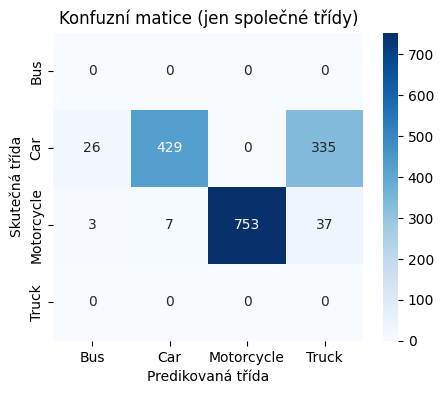

In [9]:
# Vykreslení konfuzní matice
# - Pomocí modelu se vytvoří predikce pro testovací data
# - Získají se reálné třídy a porovnají se s predikcemi
# - Pomocí seaborn se zobrazí matice jako heatmapa

# --- 7) Konfuzní matice ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Společné třídy
common_classes = ["Bus", "Car", "Motorcycle", "Truck"]
common_class_indices = [train_classes.index(cls) for cls in common_classes]

# Předpovědi
y_pred_probs = model.predict(test_ds)
y_pred_all = np.argmax(y_pred_probs, axis=1)
y_true_all = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds])

# Filtr: pouze případy, kdy true i predikce jsou ve společných třídách
valid_mask = np.logical_and(
    np.isin(y_true_all, common_class_indices),
    np.isin(y_pred_all, common_class_indices)
)

y_true_filtered = y_true_all[valid_mask]
y_pred_filtered = y_pred_all[valid_mask]

# Přemapování indexů do nového rozsahu 0...len(common_classes)
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(common_class_indices)}
y_true_mapped = np.array([index_mapping[idx] for idx in y_true_filtered])
y_pred_mapped = np.array([index_mapping[idx] for idx in y_pred_filtered])

# Konfuzní matice
cm = confusion_matrix(y_true_mapped, y_pred_mapped)

# Zobrazení
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=common_classes, yticklabels=common_classes)
plt.xlabel("Predikovaná třída")
plt.ylabel("Skutečná třída")
plt.title("Konfuzní matice (jen společné třídy)")
plt.savefig("confusion_matrix1.png", dpi=300, bbox_inches="tight")
plt.show()



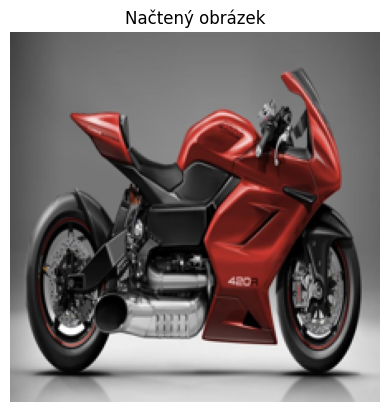

W0000 00:00:1748371358.969490  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.969616  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.969682  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.969752  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.969910  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.969979  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.970042  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.970116  337308 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748371358.970219  337308 gp

1/1 [==============================] - 1s 1s/step
Predikovaná třída: Motorcycle


In [10]:
import requests
from PIL import Image
from io import BytesIO

# URL obrázku
url = "https://s3.eu-central-1.amazonaws.com/tf-prod-plzen/data/photo/1697072/19165074.jpg"  # <- sem dej platný obrázek
url1 = "https://www.ridimauto.cz/wp-content/uploads/2021/05/bmw-x4.jpg"
url2 = "https://cdn.britannica.com/17/126517-050-9CDCBDDF/semi-semitrailer-truck-tractor-highway.jpg"
url3 = "https://images.contentstack.io/v3/assets/blte891c850d5781579/blt53faefb3dffea48c/6452c0632beffe356089eb86/why-is-it-called-a-semi-truck.jpg"
url4 = "https://img.redbull.com/images/q_auto,f_auto/redbullcom/2016/05/18/1331795515580_2/nejrychlej%C5%A1%C3%AD-motorky-sv%C4%9Bta---mtt-turbine-sbk-y2k.jpg"

# Načtení a otevření obrázku přímo z internetu
response = requests.get(url4)
im = Image.open(BytesIO(response.content)).convert("RGB")

# Pokračuj jako obvykle
im = im.resize(image_size)

# Zobraz obrázek
import matplotlib.pyplot as plt
plt.imshow(im)
plt.axis("off")
plt.title("Načtený obrázek")
plt.show()

# Předzpracování
img_array = tf.keras.preprocessing.image.img_to_array(im)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Predikce
prediction = model.predict(img_array)
predicted_label = train_classes[np.argmax(prediction)]

print(f"Predikovaná třída: {predicted_label}")


